### Inference Segmenter

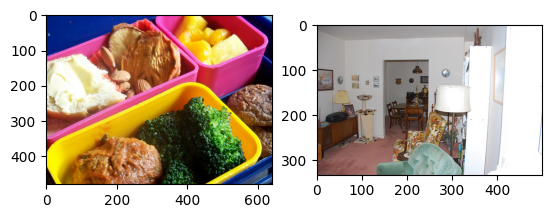

In [76]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2
import data_utils.dataset as ds
from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation
import numpy as np

# load MaskFormer fine-tuned on COCO panoptic segmentation
feature_extractor = MaskFormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-large-coco")
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-large-coco")

batch_size = 2

#read and transform images
image = cv2.imread("datasets/images/train2014/COCO_train2014_000000000009.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image2 = cv2.imread("datasets/images/train2014/COCO_train2014_000000001155.jpg")
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[1].imshow(image2)


In [ ]:
def extract_segments(seg_mask: torch.Tensor, seg_info: list[dict], image: torch.Tensor) -> torch.Tensor:
    """
    Extracting segments from given image corresponding segmentation mask
    """
    #creating and concating maps for each class, reshaping [height, width] -> [1, height, width] 
    class_maps = torch.cat([seg_mask[None, :, :] == value['id'] for value in seg_info], dim=0)
    class_maps = class_maps.to(torch.uint8)

    # edding extra dimension for extracting from image [seg_mask_for_class, height, width] -> [seg_mask_for_class, chnnels ,height, width]
    class_maps = class_maps[:, None, :, :]
    class_maps = class_maps.repeat(1, 3, 1, 1)
    extracted_segments = image * class_maps
    return extracted_segments

In [77]:
image.shape, image2.shape

((480, 640, 3), (332, 500, 3))

In [78]:
transformed_image = ds.affine_transform(image, (480, 640))
transformed_image2 = ds.affine_transform(image2, (480, 640))


In [79]:
transformed_image.shape, transformed_image2.shape

((480, 640, 3), (480, 640, 3))

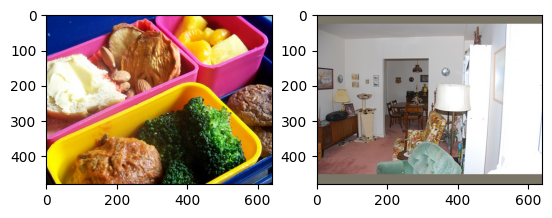

In [80]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(transformed_image)
axs[1].imshow(transformed_image2)

In [81]:
transformed_image.shape

(480, 640, 3)

In [82]:
tensor_img = torch.from_numpy(transformed_image.transpose(2, 0, 1))
tensor_img2 = torch.from_numpy(transformed_image2.transpose(2, 0, 1))

In [83]:
batch_size = 2

#Если нужно ручками батч прокинуть
batch = torch.concat((tensor_img, tensor_img2)).view(batch_size, 3, 480, 640)

inputs = feature_extractor(images=batch, return_tensors="pt", do_rescale=False)
outputs = model(**inputs)

#если нужны данные до предобработки
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits


result = feature_extractor.post_process_panoptic_segmentation(outputs, target_sizes=[batch.size()[2:]]*batch_size)

masks = [extract_segments(result[i]['segmentation'], result[i]['segments_info'], batch[i]) for i in range(batch_size)]

`label_ids_to_fuse` unset. No instance will be fused.


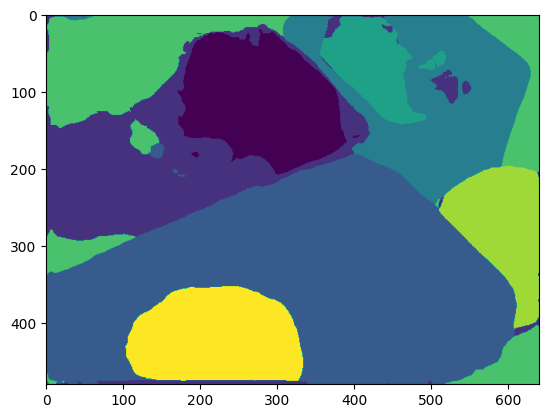

In [84]:
ax = plt.gca()
ax.imshow(result[0]['segmentation'])

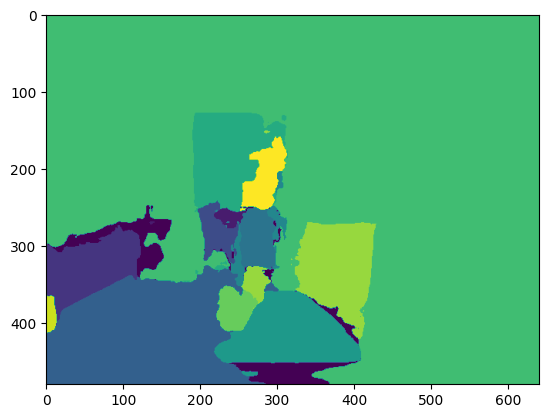

In [85]:
ax = plt.gca()
ax.imshow(result[1]['segmentation'])

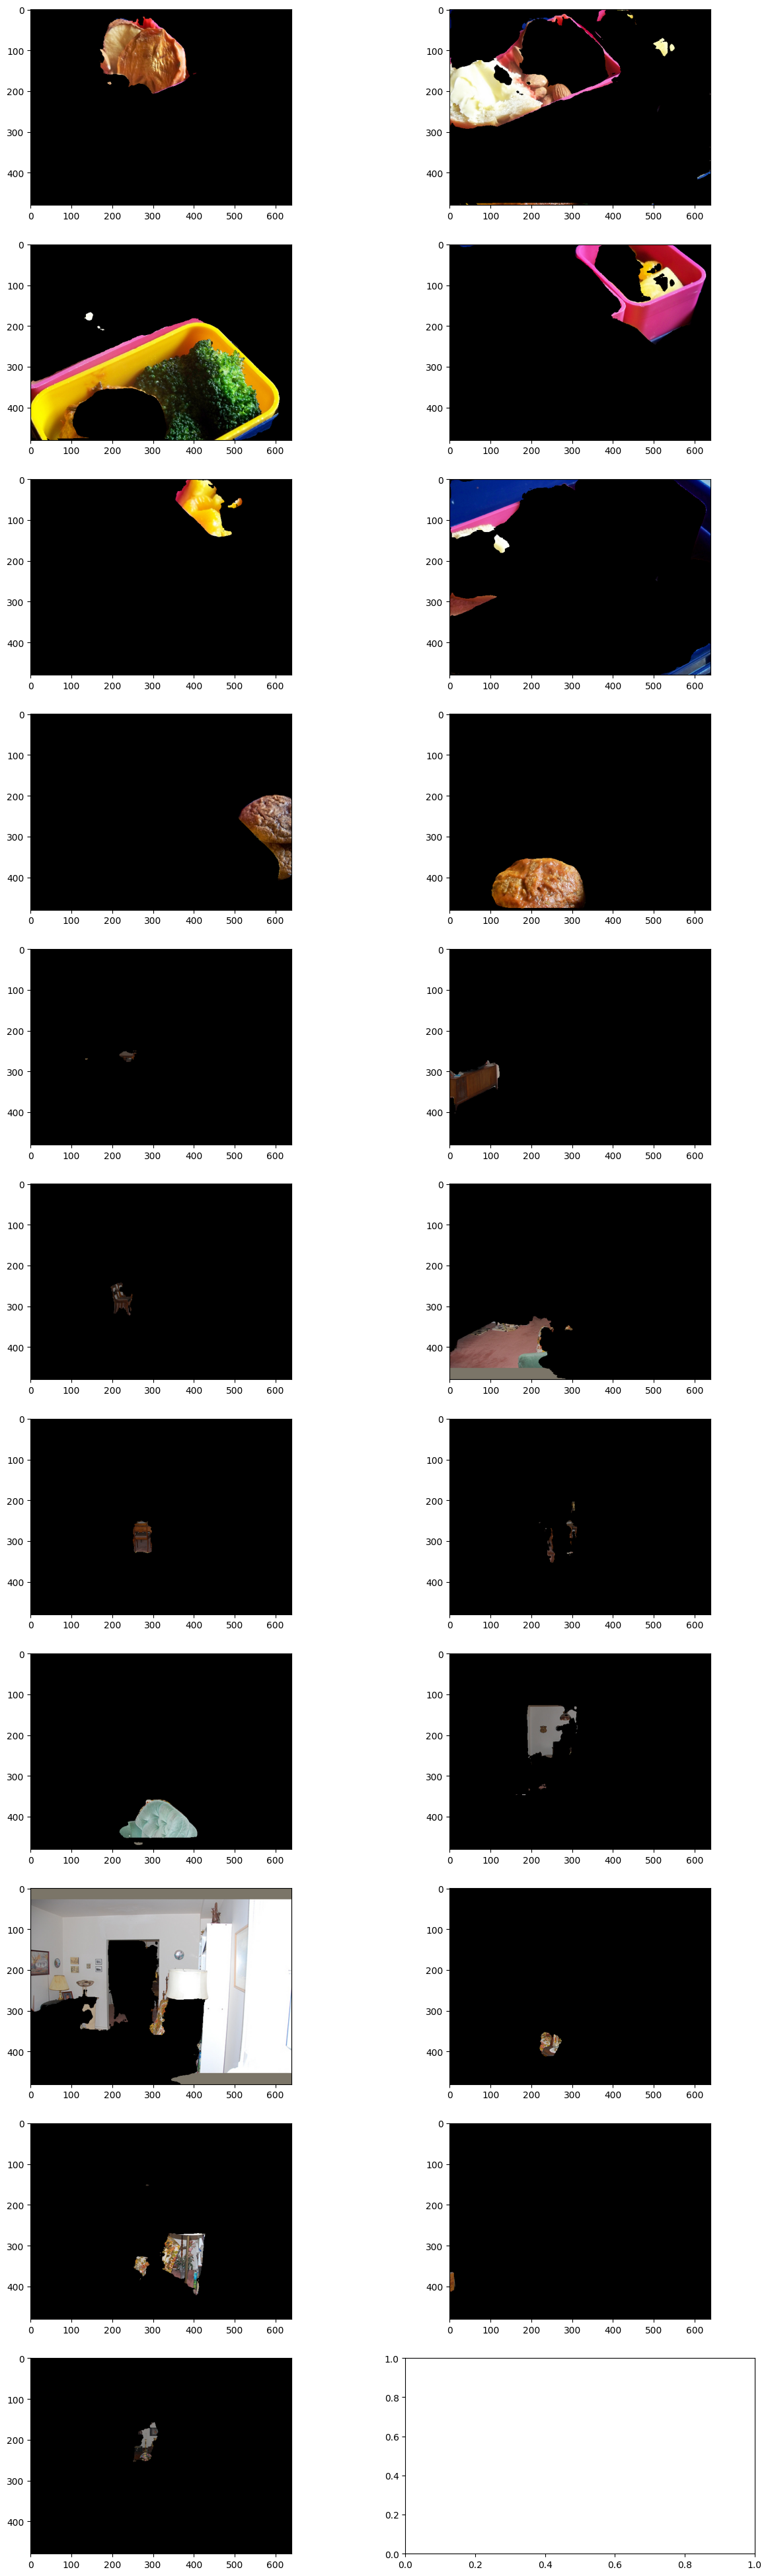

In [86]:
lens = [len(m) for m in masks]
s = sum(lens)
fig, axs = plt.subplots(int(np.ceil(s / 2)), 2, figsize = (15, 50))
i = 0
j = 0
for mask_group in masks:
    for mask in mask_group:
        axs[i, j].imshow(mask.permute(1, 2, 0))
        if (j + 1) % 2 == 0:
            i += 1
            j = 0
        else:
            j += 1

### TestDataset

In [1]:
import yaml
import torch
from data_utils.dataset import ReferenceDataset#, collate_train_batch
from data_utils.tokenizer import get_bert_tokenizer
from torch.utils.data import DataLoader

def get_config(path):
    with open(path, 'r') as f:
        config = yaml.safe_load(f)
    return config

In [2]:
config = get_config("configs/stage_one.yaml")
tokenizer = get_bert_tokenizer(config['model']['text_backbone'])

In [3]:

train_data = ReferenceDataset(
    **config['data']['train'],
    tokenizer=tokenizer
)

Error: datasets/lmdb/refcoco/train.lmdb: No such file or directory

In [4]:
train_dataloader = DataLoader(
    train_data,
    batch_size=config['train_settings']['batch_size'],
    shuffle=True,
    pin_memory=True,
    drop_last=True,
    #num_workers=8
)

In [5]:
imgs, masks, n_m, sents, att_mask = next(iter(train_dataloader))

In [6]:
imgs.size(), masks.size(), sents.size(), n_m.size()

AttributeError: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


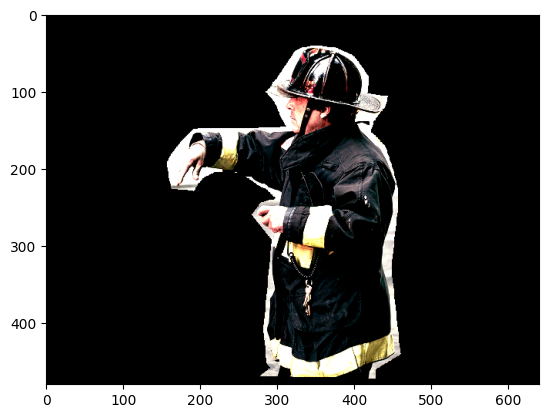

In [10]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.imshow(masks[1].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


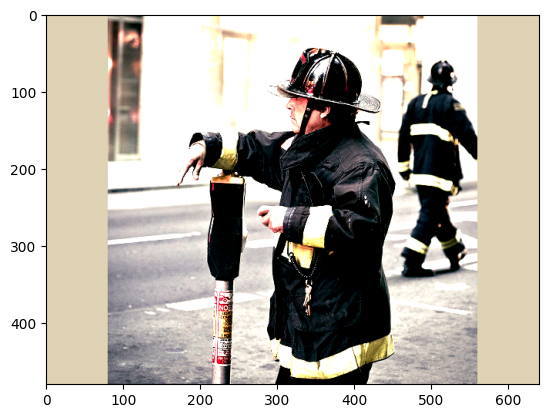

In [11]:
ax = plt.gca()
ax.imshow(imgs[1].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


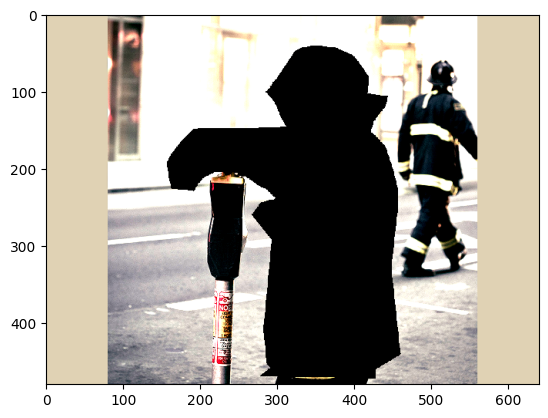

In [12]:
ax = plt.gca()
ax.imshow(n_m[1].permute(1, 2, 0))